# __THƯ VIỆN__

In [1]:
import pandas as pd
import numpy as np
import torch
import ast

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split

import string
import advertools as adv
import emoji
import regex as re
from underthesea import word_tokenize, pos_tag

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import import_ipynb
import MLTunning as MLT

# __PREPROCESS__

In [3]:
def preprocess_single_comment_2(comment, teencode_dict_path):
    # 1. Convert text to lowercase
    comment = comment.lower()

    # 2. Load teencode dictionary
    teencode_dict = dict(pd.read_csv(teencode_dict_path, delimiter='\t').values)

    # 3. Handle teencode
    def handle_teencode(text, teencode_dict):
        return ' '.join([teencode_dict[word] if word in teencode_dict else word for word in text.split(' ')])
    comment = handle_teencode(comment, teencode_dict)

    # 4. Standardize stretched words (e.g., "heeeellooo" -> "helo")
    comment = re.sub(r'(\D)\1+', r'\1', comment)

    # 5. Remove words with length greater than 7
    def remove_words_over_length(text, length):
        return ' '.join([word for word in text.split(' ') if len(word) <= length])
    comment = remove_words_over_length(comment, 7)

    # 6. Remove white spaces, \n, \t, \r, \v
    comment = re.sub(r'\s+', ' ', comment.strip())

    # 7. Remove numbers and special characters
    def remove_numbers_and_special_characters(text):
        text = re.sub(r'[' + string.punctuation + ']', '', text)  # Remove special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        return text
    comment = remove_numbers_and_special_characters(comment)

    # 8. Tokenize text using word_tokenize from underthesea
    tokenized_comment = word_tokenize(comment, format='text')

    return tokenized_comment

In [4]:
def preprocess_text(dataset, col_name, teencode_dict_path):
    # 1. Convert text to lowercase
    dataset[col_name] = dataset[col_name].str.lower()

    # 2. Load teencode dictionary
    teencode_dict = dict(pd.read_csv(teencode_dict_path, delimiter='\t').values)

    # 3. Handle teencode
    def handle_teencode(text, teencode_dict):
        return ' '.join([teencode_dict[word] if word in teencode_dict else word for word in text.split(' ')])

    dataset[col_name] = dataset[col_name].apply(lambda x: handle_teencode(str(x), teencode_dict))

    # 4. Standardize stretched words (e.g., "heeeellooo" -> "helo")
    dataset[col_name] = dataset[col_name].apply(lambda x: re.sub(r'(\D)\1+', r'\1', str(x)))

    # 5. Remove words with length greater than 7
    def remove_words_over_length(text, length):
        return ' '.join([word for word in text.split(' ') if len(word) <= length])

    dataset[col_name] = dataset[col_name].apply(lambda x: remove_words_over_length(str(x), 7))

    # 6. Remove white spaces, \n, \t, \r, \v
    dataset[col_name] = dataset[col_name].apply(lambda x: re.sub(r'\s+', ' ', str(x).strip()))

    # 7. Remove numbers and special characters
    def remove_numbers_and_special_characters(text):
        text = re.sub(r'[' + string.punctuation + ']', '', text)  # Remove special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        return text

    dataset[col_name] = dataset[col_name].apply(lambda x: remove_numbers_and_special_characters(str(x)))

    #8. Drop NA data
    dataset.dropna(subset=[col_name], inplace=True)

    # 9. Tokenize text using word_tokenize from underthesea
    dataset['word_tokenize'] = dataset[col_name].apply(lambda x: word_tokenize(str(x), format='text'))

    return dataset

In [5]:
import re
import pandas as pd

def preprocess_single_comment(comment):
    """
    Tiền xử lý một bình luận duy nhất, tách thành các câu riêng biệt và trả về DataFrame chứa các câu.
    
    Args:
        comment: Một chuỗi chứa bình luận.
    
    Returns:
        comment_tachs: DataFrame chứa các câu đã tách với thông tin chỉ số (idx) của bình luận gốc.
    """
    columns = ['idx', 'comment']
    comment_tachs = pd.DataFrame(columns=columns)

    # Xử lý NaN hoặc các giá trị không phải chuỗi
    comment = str(comment) if comment is not None else ""  # Chuyển comment thành chuỗi

    if '\n\n' in comment: 
        comment = comment.split('\n\n')[1]  # Lấy phần sau dấu '\n\n'
    
    # Tách câu dựa trên dấu câu hoặc xuống dòng
    sentences = re.split(r'[,.!?;]\s*|\n', comment)
    sentences = [s.strip() for s in sentences if s.strip()]  # Loại bỏ chuỗi rỗng và khoảng trắng thừa

    # Lưu từng câu vào DataFrame
    for sentence in sentences:
        new_row = {'idx': 0, 'comment': sentence}  # idx = 0 vì chỉ có một comment duy nhất
        comment_tachs.loc[len(comment_tachs)] = new_row

    return comment_tachs

In [6]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(line.strip() for line in f)
    return stopwords

In [7]:
STOPWORDS_FILE = "vietnamese-stopwords.txt"
stopwords_vietnamese = load_stopwords(STOPWORDS_FILE)

def process_tweet_vietnamese(tweet):

    # Tokenize bằng underthesea (tách từ)
    tweet_tokens = word_tokenize(tweet, format="text").split()

    # Làm sạch token
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_vietnamese and word not in string.punctuation:
            tweets_clean.append(word.lower())  # Đưa về chữ thường

    return tweets_clean

In [8]:
def freq_sentence_CS(keys, label_check, vocab):
    data_freq = []

    for word in keys:
    
        dict_count = {}
        for col in label_check:
            dict_count[col] = 0
        
        for idx, i in enumerate(label_check):
            if (word, idx) in vocab:
                dict_count[i] = vocab[(word, idx)]
            
        list_temp = [word]
        list_temp.extend(dict_count.values())
        data_freq.append(list_temp)
    return data_freq

In [9]:
def create_data_CS(comments, label_check, vocab):
    temp = ['idx', 'bias'] + label_check
    df_ = pd.DataFrame(columns = temp)
    for idx, tweet in enumerate(comments):
        list_freq = freq_sentence_CS(process_tweet_vietnamese(tweet), label_check, vocab)

        dict_count = {}
        for col in label_check:
            dict_count[col] = 0
            
        for index, row in enumerate(list_freq):
            row = row[1:]
            for cate, value in zip(label_check, row):
                if(type(value) == str): continue
                dict_count[cate] += value

        new_row = { 'idx': idx, 'bias': 1 }
        for label in label_check:
            new_row[label] = dict_count[label]
        
        df_.loc[len(df_)] = new_row
    return df_

In [10]:
import json

with open('vocab_category.json', 'r') as f:
    data = json.load(f)
    vocab_loaded = data['vocab']
    label = data['label']

vocab_dict = {eval(key): value for key, value in vocab_loaded.items()}
vocab_dict

{('hàng', 0): 220,
 ('cửa_hàng', 0): 38,
 ('đóng_gói', 0): 77,
 ('nhanh_chóng', 0): 12,
 ('màu_sắc', 0): 6,
 ('mô_hình', 0): 4,
 ('kích_thước', 0): 6,
 ('ủng_hộ', 0): 1,
 ('hóa', 0): 2,
 ('mô_tả', 0): 5,
 ('giao', 0): 213,
 ('thân_thiện', 0): 2,
 ('sản_phẩm', 0): 10,
 ('cẩn_thận', 0): 76,
 ('thông_tin', 0): 2,
 ('hình_ảnh', 0): 2,
 ('miễn_phí', 0): 1,
 ('vận_chuyển', 0): 13,
 ('kích_cỡ', 0): 2,
 ('ga', 0): 1,
 ('màu', 0): 2,
 ('kiểu_dáng', 0): 1,
 ('đặt_hàng', 0): 15,
 ('đầu_tiên', 0): 14,
 ('đời', 0): 2,
 ('thuy', 0): 2,
 ('thủy', 0): 2,
 ('tinh_bọc', 0): 2,
 ('da', 0): 3,
 ('sang_trọng', 0): 2,
 ('phí', 0): 1,
 ('k', 0): 1,
 ('utc', 0): 1,
 ('khái_niệm', 0): 1,
 ('thời_gian', 0): 20,
 ('nhắc', 0): 1,
 ('lĩnh_vực', 0): 1,
 ('sinh', 0): 1,
 ('đầy_đủ', 0): 1,
 ('hàng_không', 0): 4,
 ('sai', 0): 9,
 ('đánh', 0): 1,
 ('đá', 0): 1,
 ('xanh', 0): 2,
 ('đậm', 0): 1,
 ('đơn', 0): 4,
 ('chính_xác', 0): 1,
 ('mua', 0): 32,
 ('xl', 0): 1,
 ('ngắn', 0): 1,
 ('kia', 0): 3,
 ('cm', 0): 1,
 ('dịch_v

# __VECTORIZE__

In [11]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")
model = AutoModel.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

def vectorize_comment(comment):
    inputs = tokenizer(comment, return_tensors="pt", padding=True, truncation=True)
    # Lấy hidden states
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state
    sentence_embedding = hidden_states.mean(dim=1)
    return sentence_embedding.squeeze(0).numpy()

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at wonrax/phobert-base-vietnamese-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def convert_embeddings_to_tensor(df):
    embeddings = df['embedding'].apply(lambda x: tf.convert_to_tensor(np.array(x).reshape(1, -1), dtype=tf.float32))

    embeddings_tensor = np.array(embeddings.tolist())

    return embeddings_tensor

# __PREDICT__

In [54]:
file_path = r'testset.xlsx'
df = pd.read_excel(file_path)
df.head(5)

,Unnamed: 0,orderid,itemid,itemname,cmtid,ctime,rating,userid,shopid,comment,...,image_data,key_media,is_super_review,region,original_item_info,show_super_review_tag,super_review_status,template_tags,ItemRatingReply,display_variation_filter
0,0,92941960095687,11305172432,Áo sơ mi,6980041307,1640013969,1,393720644,259681663,Áo sơ mi trắng này chất lụa mặc vào mát lạnh l...,...,[{'image_id': 'acdfe3c4e513bf379e1be34828eb69a...,"{'key_media_code': 1, 'key_media_id': 'vn_091a...",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
1,1,88914825374056,11305172432,Áo sơ mi,6443720741,1635589554,1,41678132,259681663,Chất lượng sản phẩm trên cả hy vọng. \nÁo đườn...,...,[{'image_id': '194cf53082a08ce28090c3e0c75f438...,"{'key_media_code': 1, 'key_media_id': 'vn_7c48...",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
2,2,101639107204879,11305172432,Áo sơ mi,7911794551,1648665082,1,59135900,259681663,Đây là một trong những shop menswear cute nhất...,...,[{'image_id': '0d503deada278926fd8e443356d588a...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
3,3,151066957232306,11305172432,Áo sơ mi,12944626201,1697820759,1,958994801,259681663,Đúng với mô tả:đúng\nChất liệu:vải\nMàu sắc:tr...,...,[{'image_id': 'vn-11134103-7r98o-ln36f5i7e2432...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,"['Đúng với mô tả', 'Chất liệu', 'Màu sắc']",NaN,NaN
4,4,89477296313770,11305172432,Áo sơ mi,6504669981,1636185616,1,5474768,259681663,Camera mình hơi xấu nhưng mà lần đầu tiên mua ...,...,[{'image_id': '7305922d12a767bd702a0ec1ace0dff...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN


In [14]:
df = preprocess_text(df, 'comment', 'teencode.txt')
df['embedding'] = df['word_tokenize'].apply(vectorize_comment)
X = df['embedding']
y = df['rating']
X = convert_embeddings_to_tensor(df)

2024-12-17 06:08:15,490 | WARNING | saving_utils.py:256 | try_build_compiled_arguments | Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model loaded successfully!
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
Accuracy on test set: 0.93

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.87      0.93        71
    Positive       0.87      0.98      0.93        63

    accuracy                           0.93       134
   macro avg       0.93      0.93      0.93       134
weighted avg       0.93      0.93      0.93       134



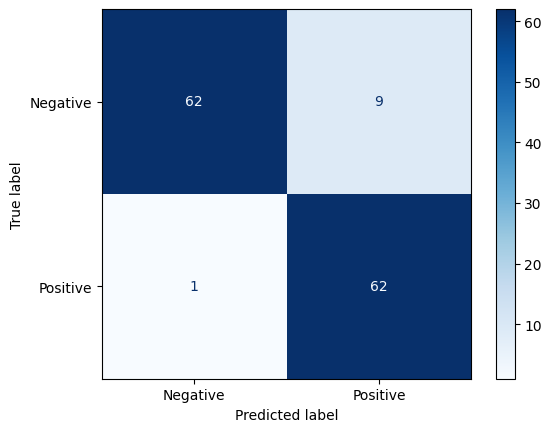

In [15]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Tải lại mô hình từ file .h5
model_path = "C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\model\\PhoBERT_LSTM_chung.h5"
model = load_model(model_path)
print("Model loaded successfully!")

# Nếu chỉ muốn dự đoán trên dữ liệu mới:
y_pred = model.predict(X)
y_pred = (y_pred > 0.5).astype(int)  # Chuyển đổi dự đoán sang nhãn nhị phân (0 hoặc 1)

# So sánh với nhãn thực tế
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["Negative", "Positive"]))

# Vẽ ma trận nhầm lẫn
ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=["Negative", "Positive"], cmap="Blues")
plt.show()

# __ỨNG DỤNG__

In [55]:
comment = 'Chất liệu ok , vải mỏng nhẹ mát . Hỗ trợ đổi trả tốt , buồn cái là đã dặn trc r vẫn để tình trạng hàng lỗi xảy ra may là khắc phục kịp'

In [56]:
# comment = 'Ulatroi tôi thích chiếc áo sơ mi này quá nè  nó rộng, thoải mái , mặc ưng cái bụng lắm luôn nha. Vải nó mát, sơ lành lạnh tui thấy sịn sò lắm. nghe nói có quà tặng 12/12 bùng nổ giá hời lắm :b shop đáng iu và thân thiện lắm nha tui tiếp tục ủng hộ nè :b 5 sao 5 sao'

In [57]:
comment_split = preprocess_single_comment(comment)

In [58]:
X_category = create_data_CS(comment_split['comment'], label, vocab_dict)
X_category = X_category.drop(columns=['idx'])

In [59]:
comment

'Chất liệu ok , vải mỏng nhẹ mát . Hỗ trợ đổi trả tốt , buồn cái là đã dặn trc r vẫn để tình trạng hàng lỗi xảy ra may là khắc phục kịp'

In [60]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")
model = AutoModel.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

def vectorize_comment(comment):
    inputs = tokenizer(comment, return_tensors="pt", padding=True, truncation=True)
    # Lấy hidden states
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state
    sentence_embedding = hidden_states.mean(dim=1)
    return sentence_embedding.squeeze(0).numpy()

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at wonrax/phobert-base-vietnamese-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
comment = preprocess_single_comment_2(comment, 'teencode.txt')
comment = vectorize_comment(comment)
comment_batch = comment.reshape(1, 1, 768)

In [62]:
comment_split = preprocess_text(comment_split, 'comment', 'teencode.txt')
comment_split['embedding'] = comment_split['word_tokenize'].apply(vectorize_comment)
X = comment_split['embedding']
X = convert_embeddings_to_tensor(comment_split)

In [63]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import joblib

# Tải lại mô hình từ file .h5
model_path = "C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\model\\PhoBERT_LSTM_chung.h5"
model = load_model(model_path)
print("Model loaded successfully!")

# Tải lại mô hình từ file .h5
model_path = "C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\model\\PhoBERT_LSTM_split.h5"
model_split = load_model(model_path)
print("Model loaded successfully!")

# Tải lại mô hình từ file .h5
model_path = "C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\model\\Freqs_Randomforest_Category.pkl"

# Tải mô hình bằng joblib
model_category = joblib.load(model_path)
print("Model loaded successfully!")

2024-12-17 08:52:10,585 | WARNING | saving_utils.py:256 | try_build_compiled_arguments | Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model loaded successfully!


2024-12-17 08:52:10,970 | WARNING | saving_utils.py:256 | try_build_compiled_arguments | Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model loaded successfully!
Model loaded successfully!


In [64]:
y_pred = model.predict(comment_batch)
y_pred_split = model_split.predict(X)
labels = model_category.predict(X_category)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [65]:
comment_split['category'] = comment_split.index.to_series().apply(lambda idx: label[labels[idx]])

In [66]:
labels

array([5, 5, 2, 0])

In [ ]:
comment = 'Chất liệu ok , vải mỏng nhẹ mát . Hỗ trợ đổi trả tốt , buồn cái là đã dặn trc r vẫn để tình trạng hàng lỗi xảy ra may là khắc phục kịp'

In [67]:
comment_split[['comment', 'category']]

,comment,category
0,chất liệu ổn,Sản phẩm và chất lượng
1,vải mỏng nhẹ mát,Sản phẩm và chất lượng
2,hỗ trợ đổi trả tốt,Khả năng quay lại
3,buồn cái là đã dặn trước rồi vẫn để tình trạng...,Đóng gói và giao hàng


In [68]:
y_pred

array([[0.78060603]], dtype=float32)

In [69]:
y_pred_split

array([[0.97084075],
       [0.98034173],
       [0.98878723],
       [0.2313423 ]], dtype=float32)

In [70]:
label

['Đóng gói và giao hàng',
 'Giá cả và giá trị',
 'Khả năng quay lại',
 'Khác',
 'Phản hồi và giao tiếp',
 'Sản phẩm và chất lượng',
 'Trả hàng/hoàn tiền',
 'Trải nghiệm']